# Train a Simple TensorFlow Lite for Microcontrollers model

This notebook demonstrates the process of training a 2.5 kB model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers. 

Deep learning networks learn to model patterns in underlying data. Here, we're going to train a network to model data generated by a [sine](https://en.wikipedia.org/wiki/Sine) function. This will result in a model that can take a value, `x`, and predict its sine, `y`.

The model created in this notebook is used in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Configure Defaults

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [2]:
! pip install tensorflow==2.4.0-rc3

Import Dependencies

In [3]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
import datetime
import seaborn as sns


# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

### 1. Generate Data

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph.

       HourlyDryBulbTemperature
0                          40.0
1                          39.0
2                          39.0
3                          39.0
4                          39.0
...                         ...
68814                      64.0
68815                      62.0
68816                      61.0
68817                      60.0
68818                      59.0

[68819 rows x 1 columns]
Index(['HourlyDryBulbTemperature'], dtype='object')


<ipython-input-4-f379e2ab5b56>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HourlyDryBulbTemperature'] = df['HourlyDryBulbTemperature'].astype(np.float32)


array([<AxesSubplot:>], dtype=object)

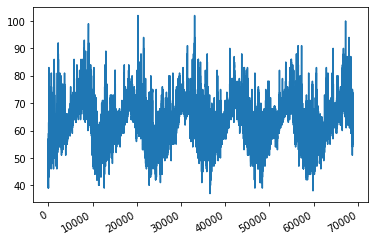

In [4]:
t = pd.read_csv('/home/mrrumpf/build/planb/vscode-template-linux/2338365-no-nans.csv')
df = t[['DATE','HourlyDryBulbTemperature']]
df['HourlyDryBulbTemperature'] = df['HourlyDryBulbTemperature'].astype(np.float32)

date_time = pd.to_datetime(df.pop('DATE'), format='%Y-%m-%d %H:%M:%S')

print(df)
print(df.columns)

#X=np.asarray(X).astype(np.float32)

uni_data = df['HourlyDryBulbTemperature']
uni_data.head()
uni_data.plot(subplots=True)

<ipython-input-5-e504ab955f8f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
<ipython-input-5-e504ab955f8f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
<ipython-input-5-e504ab955f8f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

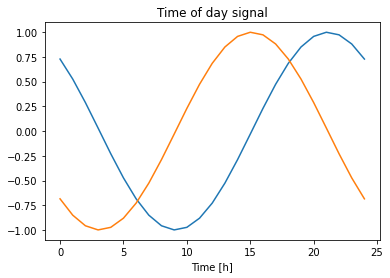

In [5]:
# Handle time periodicy
timestamp_s = date_time.map(datetime.datetime.timestamp)
#y_values = timestamp_s

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

x_values = uni_data
y_values = df['Day sin']

### 3. Split the Data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20% 

The following code will split our data and then plots each set as a different color:


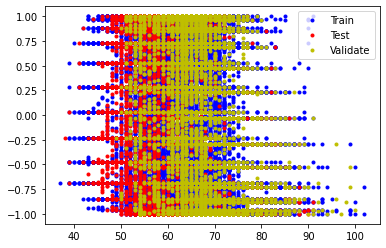

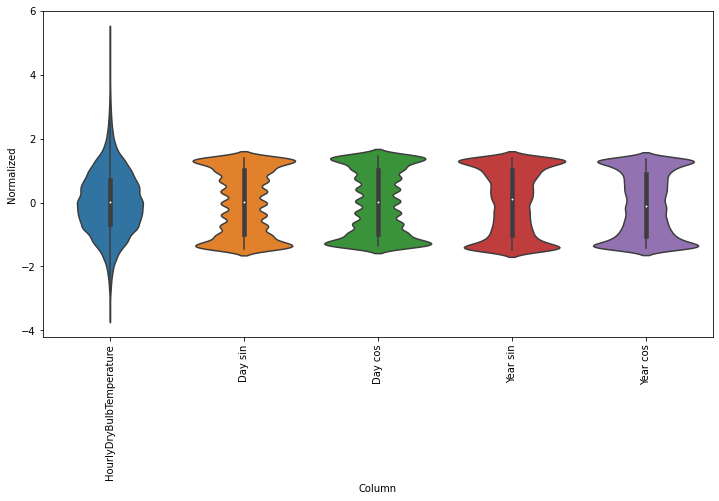

In [6]:
SAMPLES = df['HourlyDryBulbTemperature'].count()

# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.8 * SAMPLES)
TEST_SPLIT = int(0.1 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

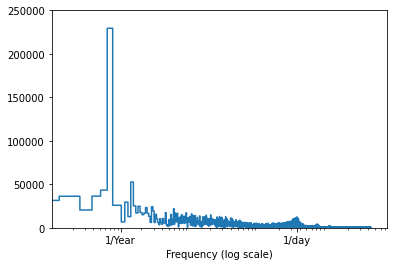

In [7]:
fft = tf.signal.rfft(df['HourlyDryBulbTemperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['HourlyDryBulbTemperature'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 250000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['HourlyDryBulbTemperature'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['HourlyDryBulbTemperature']

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [11]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
labels shape: (3, 1, 1)


In [12]:
w2.example = example_inputs, example_labels

In [13]:
def plot(self, model=None, plot_col='HourlyDryBulbTemperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

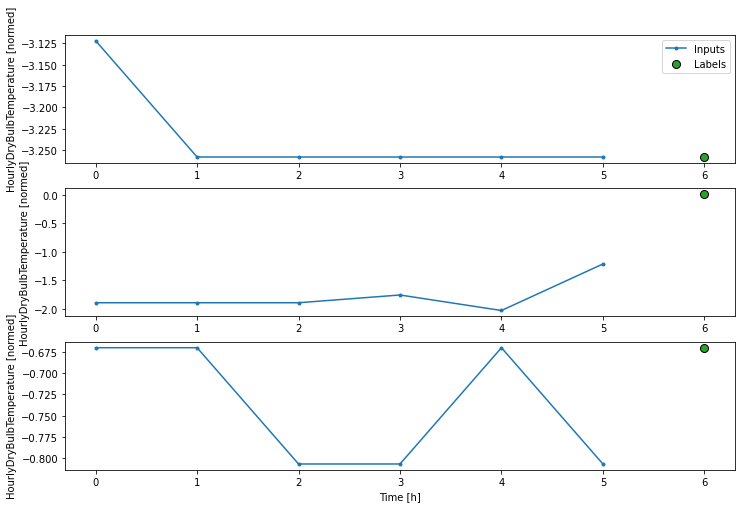

In [14]:
w2.plot()

In [15]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [16]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [17]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [18]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [19]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['HourlyDryBulbTemperature'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['HourlyDryBulbTemperature']

In [20]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [21]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [22]:
baseline = Baseline(label_index=column_indices['HourlyDryBulbTemperature'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

431/431 [==============================] - 1s 2ms/step - loss: 0.0399 - mean_absolute_error: 0.1204


In [23]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['HourlyDryBulbTemperature'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['HourlyDryBulbTemperature']

In [24]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


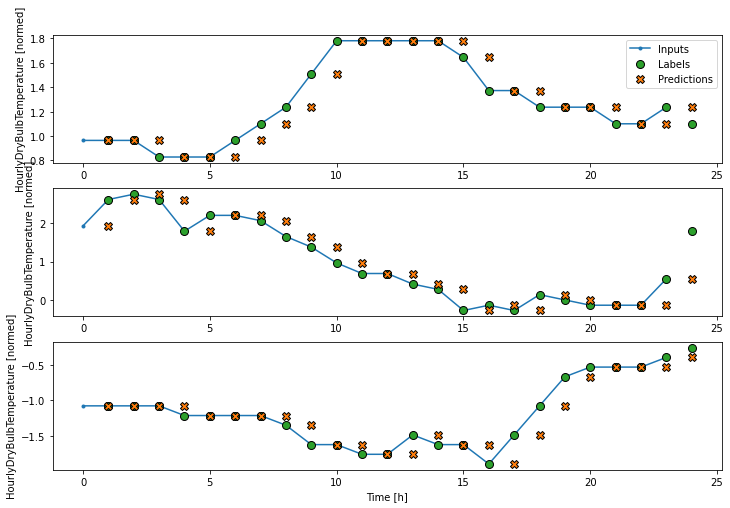

In [25]:
wide_window.plot(baseline)

In [26]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [27]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [28]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])

  # Save the model to disk
  model.save(MODEL_TF)

  return history


In [29]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1506/1506 [==============================] - 4s 2ms/step - loss: 1.8883 - mean_absolute_error: 1.0403 - val_loss: 0.2274 - val_mean_absolute_error: 0.3498
Epoch 2/20
1506/1506 [==============================] - 4s 2ms/step - loss: 0.1893 - mean_absolute_error: 0.3113 - val_loss: 0.0524 - val_mean_absolute_error: 0.1690
Epoch 3/20
1506/1506 [==============================] - 3s 2ms/step - loss: 0.0494 - mean_absolute_error: 0.1580 - val_loss: 0.0333 - val_mean_absolute_error: 0.1293
Epoch 4/20
1506/1506 [==============================] - 3s 2ms/step - loss: 0.0374 - mean_absolute_error: 0.1336 - val_loss: 0.0330 - val_mean_absolute_error: 0.1279
Epoch 5/20
1506/1506 [==============================] - 3s 2ms/step - loss: 0.0373 - mean_absolute_error: 0.1332 - val_loss: 0.0330 - val_mean_absolute_error: 0.1273
Epoch 6/20
1506/1506 [==============================] - 3s 2ms/step - loss: 0.0373 - mean_absolute_error: 0.1331 - val_loss: 0.0330 - val_mean_absolute_error: 0.1277
Epoc

In [30]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


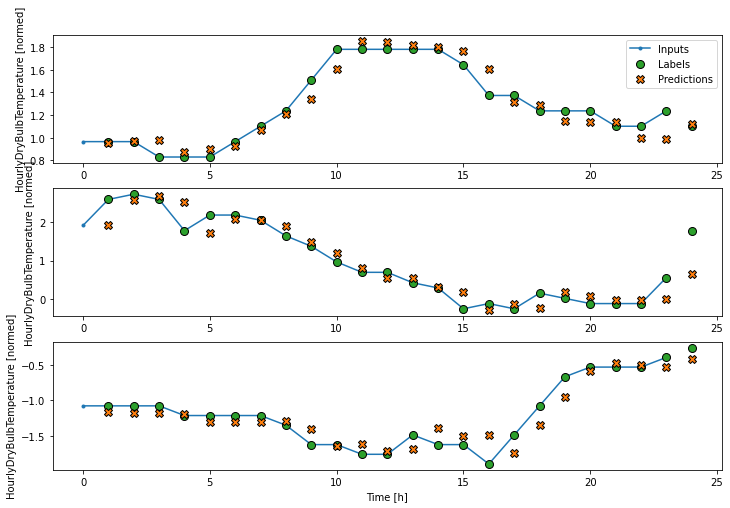

In [31]:
wide_window.plot(linear)

## Convert to TF Lite

### 1. Generate Models with or without Quantization
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of a model is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

In the following cell, we'll convert the model twice: once with quantization, once without.

In [32]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

2632

In [33]:
train_df.count()

HourlyDryBulbTemperature    48173
Day sin                     48173
Day cos                     48173
Year sin                    48173
Year cos                    48173
dtype: int64

## Size

In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
#size_tflite = os.path.getsize(MODEL_TFLITE)

In [ ]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"]],
     #["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

## Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
#!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

## Deploy to a Microcontroller

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}